In [ ]:
!pip install datasets
!pip install simpletransformers
!pip install tensorboardx
!pip install nltk contractions
!pip install googletrans==4.0.0-rc1
!pip install transformers[torch]
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.6 MB

### Imports

In [ ]:
import pandas as pd
import ast
import transformers
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import os
import nltk
import string
import random
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

from transformers import Trainer
from datasets import load_metric
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import TrainerCallback
from transformers import EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
from urllib import request
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from itertools import chain
from googletrans import Translator, LANGUAGES
import contractions


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


In [ ]:
# Prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
os.environ["WANDB_DISABLED"] = "true"

# Check GPU
cuda_available = torch.cuda.is_available()

if cuda_available:
    device = "cuda"
else:
    device = "cpu"

print('Cuda available? ',cuda_available)

Cuda available?  True


### Load data from module


In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', '.')

In [ ]:
dpm.load_task1()

### Load paragraph IDs

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [ ]:
data=dpm.train_task1_df

In [ ]:
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


### Rebuild training and test set

In [ ]:
# train and test set will contain par_id, label, text, country, keyword, and orig_label
rows = []
for idx in range(len(trids)):
  parid = trids.par_id[idx]

  # Select row from original dataset to retrieve data
  row = data.loc[data.par_id == parid]
  text = row.text.values[0]
  label = row.label.values[0]
  country = row.country.values[0]
  keyword = row.keyword.values[0]
  orig_label = row.orig_label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'country':country,
      'keyword':keyword,
      'orig_label':orig_label,
  })

In [ ]:
trdf1 = pd.DataFrame(rows)

In [ ]:
rows = []
for idx in range(len(teids)):
  parid = teids.par_id[idx]

  # Select row from original dataset to retrieve data
  row = data.loc[data.par_id == parid]
  text = row.text.values[0]
  label = row.label.values[0]
  country = row.country.values[0]
  keyword = row.keyword.values[0]
  orig_label = row.orig_label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'country':country,
      'keyword':keyword,
      'orig_label':orig_label,
  })

In [ ]:
tedf1 = pd.DataFrame(rows)

In [ ]:
trdf1.value_counts('label')

label
0    7581
1     794
dtype: int64

In [ ]:
tedf1

,par_id,text,label,country,keyword,orig_label
0,4046,We also know that they can benefit by receivin...,1,us,hopeless,3
1,1279,Pope Francis washed and kissed the feet of Mus...,1,ng,refugee,4
2,8330,Many refugees do n't want to be resettled anyw...,1,ng,refugee,2
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,ie,in-need,4
4,4089,"""In a 90-degree view of his constituency , one...",1,pk,homeless,3
...,...,...,...,...,...,...
2089,10462,"The sad spectacle , which occurred on Saturday...",0,gh,homeless,0
2090,10463,""""""" The Pakistani police came to our house and...",0,pk,refugee,0
2091,10464,"""When Marie O'Donoghue went looking for a spec...",0,ie,disabled,0
2092,10465,"""Sri Lankan norms and culture inhibit women fr...",0,lk,women,1


### Baseline Model: Logistic Regression and Bag of Words

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [ ]:
training_set1 = training_set1.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# train test splits
X_train1, X_test1, y_train1, y_test1 = train_test_split(training_set1['text'], training_set1['label'], test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(trdf1['text'], trdf1['label'], test_size=0.2, random_state=42)



In [ ]:
# TF-IDF with original data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectors = vectorizer.fit_transform(X_train2)
X_test_vectors = vectorizer.transform(tedf1.text)

model = LogisticRegression()
model.fit(X_train_vectors, y_train2)

predictions = model.predict(X_test_vectors)


print("Accuracy:", accuracy_score(tedf1.label, predictions))
print("F1 score:", f1_score(tedf1.label, predictions, average='binary'))


Accuracy: 0.9049665711556829
F1 score: 0.019704433497536946


In [ ]:
#Bag of words with original data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectors = vectorizer.fit_transform(X_train2)
X_test_vectors = vectorizer.transform(tedf1.text)

model = LogisticRegression()
model.fit(X_train_vectors, y_train2)

predictions = model.predict(X_test_vectors)

print("Accuracy:", accuracy_score(tedf1.label, predictions))
print("F1 score:", f1_score(tedf1.label, predictions, average='binary'))

Accuracy: 0.897803247373448
F1 score: 0.218978102189781


In [ ]:
#TF-IDF with downsampled data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectors = vectorizer.fit_transform(X_train1)
X_test_vectors = vectorizer.transform(tedf1.text)

model = LogisticRegression()
model.fit(X_train_vectors, y_train1)

predictions = model.predict(X_test_vectors)

print("Accuracy:", accuracy_score(tedf1.label, predictions))
print("F1 score:", f1_score(tedf1.label, predictions, average='binary'))


Accuracy: 0.8863419293218721
F1 score: 0.27878787878787875


In [ ]:
#Bag of Words with downsampled data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectors = vectorizer.fit_transform(X_train1)
X_test_vectors = vectorizer.transform(tedf1.text)

model = LogisticRegression()
model.fit(X_train_vectors, y_train1)

predictions = model.predict(X_test_vectors)

print("Accuracy:", accuracy_score(tedf1.label, predictions))
print("F1 score:", f1_score(tedf1.label, predictions, average='binary'))

Accuracy: 0.8247373447946514
F1 score: 0.31910946196660483


### Baseline Model: RoBERTaforSequenceClassification

In [ ]:
model_args = ClassificationArgs(num_train_epochs=2,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True)
base_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = model_args,
                                  num_labels=2,
                                  use_cuda=cuda_available)
# train model
base_model.train_model(training_set1[['text', 'label']])
# run predictions
base_preds, _ = base_model.predict(tedf1.text.tolist())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
true_labels = tedf1.label
accuracy = accuracy_score(true_labels, base_preds)
print(f'Accuracy: {accuracy}')
f1 = f1_score(true_labels, base_preds, average='binary')
print(f'F1 Score: {f1}')

Accuracy: 0.8428844317096467
F1 Score: 0.48188976377952764


# Improved RoBERTaforSequenceClassification model

## Preprocessing

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts."""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "R": wordnet.ADV,
                "V": wordnet.VERB,
                "N": wordnet.NOUN}
    return tag_dict.get(tag, wordnet.NOUN)

def expand_contractions(text, contractions_dict):
    for contraction, expanded in contractions_dict.items():
        text = text.replace(contraction, expanded)
    return text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token.lower() not in stop_words]
    # Join the lemmatized tokens back into a single string
    return ' '.join(lemmatized_tokens)

def preprocess_sentence(sentence, contractions_dict):
    sentence = expand_contractions(sentence, contractions_dict)
    sentence = remove_punctuation(sentence)
    sentence = remove_stopwords_and_lemmatize(sentence)
    return sentence

contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "I'm": "I am",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "mightn't": "might not",
    "mustn't": "must not"
}


In [ ]:
trdf1.value_counts('label')

label
0    7581
1     794
dtype: int64

In [ ]:
#preprocess train set
trdf1['text'] = trdf1['text'].apply(lambda x: preprocess_sentence(x, contractions_dict))


In [ ]:
train_df, test_df = train_test_split(trdf1, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_df.value_counts('label')

label
0    6073
1     627
dtype: int64

In [ ]:
# preprocess internal dev set
test_df['text'] = test_df['text'].apply(lambda x: preprocess_sentence(x, contractions_dict))

NameError: name 'preprocess_sentence' is not defined

In [ ]:
len(test_df)

## Data Augmentation





### Synonym Replacement

In [ ]:
def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts."""
    tag_dict = {"J": wn.ADJ,
                "R": wn.ADV}
    return tag_dict.get(tag[0], None)

def synonym_replacer(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    replaced_text = []
    for word, tag in tagged_tokens:
        wn_tag = get_wordnet_pos(tag)
        #if the word is an adjective or adverb and not a stopword, try to replace it
        if wn_tag and word.lower() not in stopwords.words('english'):
            # Get synonyms
            synonyms = set(chain.from_iterable([lemma.name() for lemma in syn.lemmas()] for syn in wn.synsets(word, wn_tag)))
            if synonyms:
                synonyms.discard(word)  #remove the original word from synonyms
                if synonyms:
                    #replace with a synonym
                    replaced_word = random.choice(list(synonyms))
                    replaced_text.append(replaced_word)
                    continue
        #if not replaced, keep the original word
        replaced_text.append(word)

    return ' '.join(replaced_text)

In [ ]:
#replace synonyms of positive class
positive_class_df = train_df[train_df['label'] == 1].copy()

positive_class_df['text'] = positive_class_df['text'].apply(synonym_replacer)

# synonym replacement dataframe
synonym_df = pd.DataFrame({
    'par_id': positive_class_df['par_id'].values,
    'text': positive_class_df['text'].values,
    'label': positive_class_df['label'].values,
    'country': positive_class_df['country'].values,
    'keyword': positive_class_df['keyword'].values,
    'orig_label': positive_class_df['orig_label'].values

})

train_df_augmented = pd.concat([train_df, synonym_df], ignore_index=True)



In [ ]:
train_df_augmented.value_counts('label')

label
0    6073
1    1254
dtype: int64

### Random Swap

In [ ]:
#NOT USED
def random_swap(sentence, n=2):  # Swaps n pairs of words in the sentence
    words = sentence.split()
    length = len(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

### Language translation

In [ ]:
def translate_texts(texts, languages=['fr', 'es', 'de']):
    translator = Translator()
    augmented_texts = []

    for text in tqdm(texts, desc="Translating"):
        dest_language = random.choice(languages)  # Select a random language
        try:
            # Translate to the selected language
            translated = translator.translate(text, dest=dest_language)
            # Translate back to English
            back_to_english = translator.translate(translated.text, dest='en')
            augmented_texts.append(back_to_english.text)
        except Exception as e:
            print(f"Error during translation: {e}")
            augmented_texts.append(text)

    return augmented_texts

In [ ]:
# translate positive class of train dataset
positive_class_df = train_df[train_df['label'] == 1].copy()

translated_texts = translate_texts(positive_class_df['text'].tolist(), languages=['fr', 'es', 'de'])

Translating:  61%|██████    | 384/627 [17:33<14:06,  3.48s/it]

Error during translation: The read operation timed out


Translating:  68%|██████▊   | 424/627 [19:28<14:49,  4.38s/it]

Error during translation: The read operation timed out


Translating:  68%|██████▊   | 426/627 [19:35<13:26,  4.01s/it]

Error during translation: The read operation timed out


Translating:  68%|██████▊   | 427/627 [19:40<14:22,  4.31s/it]

Error during translation: The read operation timed out


Translating: 100%|██████████| 627/627 [28:54<00:00,  2.77s/it]


In [ ]:
# dataframe of translated text
translated_df = pd.DataFrame({
    'par_id': positive_class_df['par_id'].values,
    'text': translated_texts,
    'label': positive_class_df['label'].values,
    'country': positive_class_df['country'].values,
    'keyword': positive_class_df['keyword'].values,
    'orig_label': positive_class_df['orig_label'].values

})

In [ ]:
train_df_translated = pd.concat([train_df, translated_df], ignore_index=True)


In [ ]:
# shuffle train_df_translated
train_df_translated = train_df_translated.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
train_df_translated.value_counts('label')

label
0    6073
1    1254
dtype: int64

In [ ]:
train_df_translated

,par_id,text,label,country,keyword,orig_label
0,5378,The new year brought housing inequality into s...,0,gb,homeless,0
1,3532,Help is yet to come to residents of Zabzugu in...,0,gh,homeless,0
2,8027,' If very poor families sing to their children...,1,gb,poor-families,4
3,546,The three-part proposal would repeal the law k...,0,in,vulnerable,0
4,1559,French President Emmanuel Macron came out Satu...,0,ng,migrant,0
...,...,...,...,...,...,...
7322,6259,""""""" Helping people in need is a message that e...",1,ca,in-need,4
7323,4512,Authorities in the central Chinese city of Cho...,0,hk,women,0
7324,6938,Rejecting reports that Sri Lanka had suspended...,0,lk,refugee,0
7325,6714,""""""" That 's a good signal that the embassy is ...",0,ph,migrant,0


## Train the model

In [ ]:
#initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#use roberta's BTE tokenizer to tokenize train and dev sets
def tokenize_texts(texts):
    processed = []
    for text in texts:
        processed.append(text)
    return tokenizer(processed, truncation=True, padding=True)

In [ ]:
train_encoding = tokenize_texts(list(train_df_translated.keyword+train_df_translated.country+train_df_translated.text))
dev_encoding = tokenize_texts(list(test_df.keyword+test_df.country+test_df.text))

In [ ]:
def get_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    rec = recall_score(labels, preds)
    prec = precision_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {'accuracy': acc, 'recall': rec, 'precision': prec, 'f1': f1,}


class RoBERTaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

#custom callback to log metrics -- NOT USED
# class MetricsLoggingCallback(TrainerCallback):
#     def __init__(self):
#         super().__init__()
#         self.losses = []
#         self.eval_metrics = {'accuracy': [], 'f1': [], 'precision': [], 'recall': []}

#     def on_log(self, args, state, control, logs=None, **kwargs):
#         # Log training loss
#         if 'loss' in logs:
#             self.losses.append(logs['loss'])
#         # Log evaluation metrics
#         for key in self.eval_metrics.keys():
#             if key in logs:
#                 self.eval_metrics[key].append(logs[key])

# weighted trainer for neg/pos class imbalance
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df_translated.label), y=train_df_translated.label)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        # compute weighted loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss




In [ ]:
train_dataset = RoBERTaDataset(train_encoding, list(train_df_translated.label))
dev_dataset = RoBERTaDataset(dev_encoding, list(test_df.label))

In [ ]:
# model hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=400,
    save_steps=400,
    evaluation_strategy="steps",
    learning_rate=1e-5,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=get_metrics,
)




Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# training the model
trainer.train()

model.save_pretrained('./finalmodel')

# Save the tokenizer associated with the model
tokenizer.save_pretrained('./tokenizer')


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
400,0.749700,0.895030,0.900896,0.005988,1.000000,0.011905
800,0.707000,0.704160,0.905075,0.101796,0.653846,0.176166
1200,0.711700,0.731520,0.900896,0.017964,0.600000,0.034884
1600,0.634200,0.764715,0.913433,0.233533,0.696429,0.349776
2000,0.498000,1.007014,0.912239,0.173653,0.763158,0.282927
2400,0.495200,0.726395,0.906269,0.479042,0.533333,0.504732
2800,0.546100,0.637235,0.916418,0.413174,0.621622,0.496403


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
400,0.749700,0.895030,0.900896,0.005988,1.000000,0.011905
800,0.707000,0.704160,0.905075,0.101796,0.653846,0.176166
1200,0.711700,0.731520,0.900896,0.017964,0.600000,0.034884
1600,0.634200,0.764715,0.913433,0.233533,0.696429,0.349776
2000,0.498000,1.007014,0.912239,0.173653,0.763158,0.282927
2400,0.495200,0.726395,0.906269,0.479042,0.533333,0.504732
2800,0.546100,0.637235,0.916418,0.413174,0.621622,0.496403
3200,0.482400,0.790953,0.914627,0.275449,0.676471,0.391489
3600,0.471800,0.815172,0.917612,0.395210,0.640777,0.488889
4000,0.375200,0.744918,0.920597,0.377246,0.684783,0.486486


('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.json',
 './tokenizer/merges.txt',
 './tokenizer/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.save_model("/content/drive/My Drive")

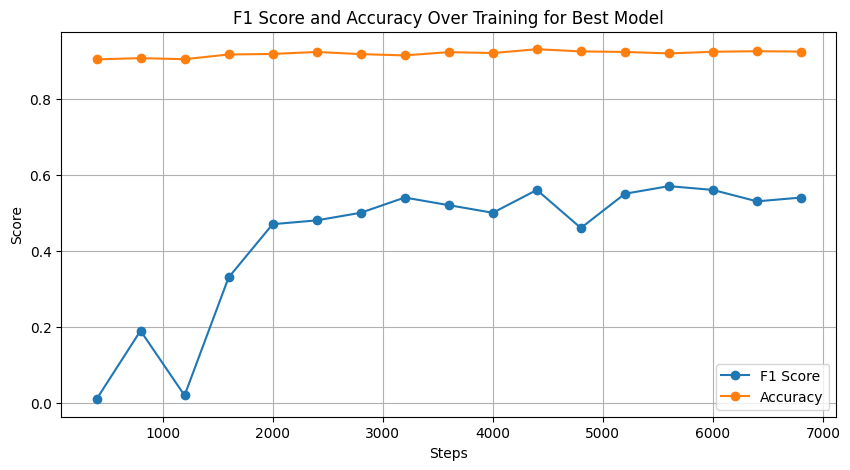

In [ ]:
steps = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 6000, 6400, 6800]  # Example steps where metrics were logged
f1_scores = [0.01, 0.19, 0.02, 0.33, 0.47, 0.48, 0.50, 0.54, 0.52, 0.50, 0.56, 0.46, 0.55, 0.57, 0.56, 0.53, 0.54]  # Replace with your F1 scores
accuracies = [0.90305, 0.906399, 0.903534, 0.915950, 0.917383, 0.922636, 0.916905, 0.913563, 0.922159, 0.919771, 0.929799, 0.924069, 0.922636, 0.918816, 0.923114, 0.924546, 0.923591]  # Replace with your accuracies

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(steps, f1_scores, label='F1 Score', marker='o')
plt.plot(steps, accuracies, label='Accuracy', marker='o')
plt.xlabel('Steps')
plt.ylabel('Score')
plt.title('F1 Score and Accuracy Over Training for Best Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.8272159099578857,
 'eval_accuracy': 0.9104477611940298,
 'eval_recall': 0.5389221556886228,
 'eval_precision': 0.5521472392638037,
 'eval_f1': 0.5454545454545455,
 'eval_runtime': 22.0919,
 'eval_samples_per_second': 75.82,
 'eval_steps_per_second': 18.966,
 'epoch': 3.0}

In [ ]:
pred = trainer.predict(dev_dataset)

In [ ]:
preds = pred.predictions.argmax(-1)
true_labels = tedf1.label
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Accuracy: 0.9235912129894938
F1 Score: 0.605911330049261


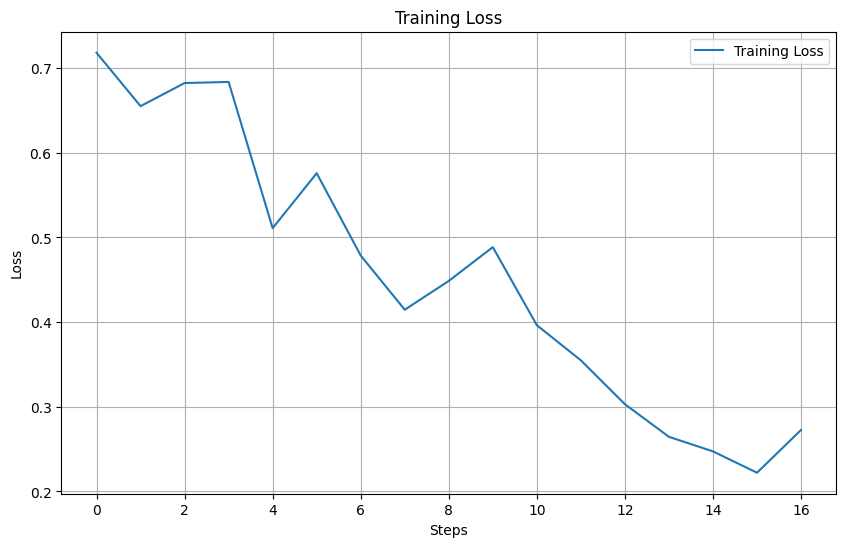

In [ ]:
training_losses = []
evaluation_losses = []
f1scores = []

for log in trainer.state.log_history:
    if 'f1' in log:
        f1score.append(log['f1'])
    if 'loss' in log and 'eval_loss' not in log:  # Training loss
        training_losses.append(log['loss'])
    elif 'eval_loss' in log:  # Evaluation loss
        evaluation_losses.append(log['eval_loss'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')

# plt.plot(evaluation_losses, label='Evaluation Loss', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
 with open("dev.txt", "w") as f:
    for i in range(len(preds)):
        f.write(str(preds[i]) + "\n")

### Official Test set


In [ ]:
column_names = ['par_id', 'art_id', 'keyword', 'country', 'text']
official_test = pd.read_csv('task4_test.tsv', sep='\t', names=column_names, header=None)


In [ ]:
len(official_test)

3832

In [ ]:
class RoBERTaDatasetWithoutLabels(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


In [ ]:
official_test_encoding = tokenize_texts(list(official_test.keyword+official_test.country+official_test.text))
official_test_dataset = RoBERTaDatasetWithoutLabels(official_test_encoding)


In [ ]:
preds = trainer.predict(official_test_dataset)

In [ ]:
test_preds = preds.predictions.argmax(-1)


In [ ]:
unique, frequency = np.unique(test_preds,
                              return_counts = True)

In [ ]:
len(test_preds)

3832

In [ ]:
unique, frequency

(array([0, 1]), array([3526,  306]))

In [ ]:
 with open("test.txt", "w") as f:
    for i in range(len(test_preds)):
        f.write(str(test_preds[i]) + "\n")

### Model Analysis

In [ ]:
#Performance Analysis
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# performance_by_category = {}
category_indexes = {}
level_of_offence_indexes = {}

with open("devnew.txt", "r") as file:
    predictions = [int(line.strip()) for line in file.readlines()]

tedf1['predictions'] = predictions

categories = tedf1['keyword'].unique()
levels = sorted(tedf1['orig_label'].unique())
performance_metrics = pd.DataFrame(columns=['Type', 'Category/Level', 'Accuracy', 'F1'])

# print(tedf1.dtypes)
# converting 'orig_label' from obj to int64
tedf1['orig_label'] = pd.to_numeric(tedf1['orig_label'], errors='coerce').astype('int64')


for category in categories:
    # category_indexes[category] = tedf1.index[tedf1['keyword'] == category].tolist()
    subset_df = tedf1[tedf1['keyword'] == category]
    category_accuracy = accuracy_score(subset_df['label'], subset_df['predictions'])
    # print(f"Accuracy for category {category}: {category_accuracy}")

    category_f1 = f1_score(subset_df['label'], subset_df['predictions'], average='binary')
    # performance_metrics = performance_metrics.append({'Type': 'Category', 'Category/Level': category, 'Accuracy': category_accuracy, 'F1': category_f1}, ignore_index=True)

    new_row = pd.DataFrame({'Type': ['Category'], 'Category/Level': [category], 'Accuracy': [category_accuracy], 'F1': [category_f1]})
    performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

performance_metrics = performance_metrics[performance_metrics['Type'] == 'Category'].sort_values(by='Accuracy', ascending=False)

# print("list(category_indexes.items()):", list(category_indexes.items())[:])

for level in levels:
    # category_indexes[level] = tedf1.index[tedf1['orig_label'] == level].tolist()
    subset_df = tedf1[tedf1['orig_label'] == level]
    level_accuracy = accuracy_score(subset_df['label'], subset_df['predictions'])
    if level in [0, 1]:
        # print(f"subset_df['label'], subset_df['predictions']:", subset_df['label'], subset_df['predictions'])
        # calc TP, FP, FN
        TP = ((subset_df['predictions'] == 0) & (subset_df['label'] == 0)).sum()
        FP = ((subset_df['predictions'] == 0) & (subset_df['label'] != 0)).sum()
        FN = ((subset_df['predictions'] != 0) & (subset_df['label'] == 0)).sum()

        # calc P & R
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # calc F1 score
        level_f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        new_row = pd.DataFrame({'Type': ['Level'], 'Category/Level': [level], 'Accuracy': [level_accuracy], 'F1': [level_f1]})
        performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)
    else:
        level_f1 = f1_score(subset_df['label'], subset_df['predictions'], average='binary')
        new_row = pd.DataFrame({'Type': ['Level'], 'Category/Level': [level], 'Accuracy': [level_accuracy], 'F1': [level_f1]})
        # print(f"Accuracy for level {level}: {level_accuracy}")
        performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

tedf1['text_length'] = tedf1['text'].apply(len)
minimum_length = tedf1['text_length'].min()
maximum_length = tedf1['text_length'].max()
text_length_bins = np.linspace(minimum_length, maximum_length, 21)
bin_labels = [f'{int(text_length_bins[i])}-{int(text_length_bins[i+1])}' for i in range(len(text_length_bins)-1)]
tedf1['length_bin'] = pd.cut(tedf1['text_length'], bins=text_length_bins, labels=bin_labels, include_lowest=True)

for bin_label in bin_labels:
    subset_df = tedf1[tedf1['length_bin'] == bin_label]
    if not subset_df.empty:
        accuracy = accuracy_score(subset_df['label'], subset_df['predictions'])
        f1 = f1_score(subset_df['label'], subset_df['predictions'], average='binary', zero_division=0)
    else:
        accuracy, f1 = 0, 0

    new_row = pd.DataFrame({
        'Type': ['Text Length (characters)'],
        'Category/Level': [bin_label],
        'Accuracy': [accuracy],
        'F1': [f1]})
    performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

print(performance_metrics)

In [ ]:
categories_data_melted = categories_data.melt(id_vars=['Category/Level', 'Type'], value_vars=['Accuracy', 'F1'], var_name='Metric', value_name='Value')
levels_data_melted = levels_data.melt(id_vars=['Category/Level', 'Type'], value_vars=['Accuracy', 'F1'], var_name='Metric', value_name='Value')
len_data_melted = len_data.melt(id_vars=['Category/Level', 'Type'], value_vars=['Accuracy', 'F1'], var_name='Metric', value_name='Value')

# Plot for categories
plt.figure(figsize=(5, 4))
sns.barplot(data=categories_data_melted, x='Category/Level', y='Value', hue='Metric', palette=['skyblue', 'orange'])
plt.title('Performance Metrics by Category')
plt.xlabel('Category')
plt.xticks(rotation=45, ha="right")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('performance_metrics_by_category_binaryf1.png')
plt.show()

# Plot for levels
plt.figure(figsize=(5, 4))
sns.barplot(data=levels_data_melted, x='Category/Level', y='Value', hue='Metric', palette=['skyblue', 'orange'])
plt.title('Performance Metrics by Level')
plt.xlabel('Level of Patronising')
plt.xticks(rotation=45, ha="right")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('performance_metrics_by_level_binaryf1.png')
plt.show()

# Plot for text length
plt.figure(figsize=(5, 4))
sns.barplot(data=len_data_melted, x='Category/Level', y='Value', hue='Metric', palette=['skyblue', 'orange'])
plt.title('Performance Metrics by Text Length')
plt.xlabel('Text Length by Total Characters')
plt.xticks(rotation=45, ha="right")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('performance_metrics_by_text_length_binaryf1.png')
plt.show()